In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU usage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.externals import joblib
from math import isclose
import os.path
%matplotlib inline

# Training on mean values

In [2]:
# Read data
filepath_mean = "../experimental_data/data_mean.csv"
dataset = pd.read_csv(filepath_mean, sep=",")
dataset.head()

,ch4_flow,t_center,nc,sc,m_Ni,ch4,h2,co2,co
0,50.0,600.0,3.0,3.0,0.174717,0.222502,0.610076,0.106240,0.061156
1,50.0,625.0,3.0,3.0,0.174717,0.181560,0.640715,0.103638,0.074178
2,35.0,625.0,4.0,5.0,0.174717,0.127106,0.684178,0.118278,0.070438
3,47.0,625.0,0.5,6.0,0.174717,0.137173,0.676770,0.132200,0.053858
4,50.0,625.0,2.0,4.0,0.174717,0.167882,0.652580,0.116762,0.062776


In [3]:
X = dataset.loc[:, :"m_Ni"].values
Y = dataset.loc[:, "ch4":].values

# Scale data 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0)

In [4]:
# Save scaler to file
# scaler_filename = "mean_scaler_temp.save"
# joblib.dump(scaler, scaler_filename)

In [5]:
model_name = "network_mean"
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
# early_stopping_monitor = EarlyStopping(patience=10)
loss = "mae"
metrics = ["mape"]
epochs = 5000

network = Sequential([
    Dense(25, activation=tf.nn.relu, input_shape=(5,)),
    Dense(20, activation=tf.nn.relu),
    Dense(15, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.relu),
    Dense( 4, activation=tf.nn.sigmoid)
])

network.compile(loss=loss, optimizer=optimizer, metrics=metrics)
hist = network.fit(X_train, Y_train, batch_size=X_train.shape[0], epochs=epochs, verbose=0,
                 validation_data=(X_test, Y_test), shuffle=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# Save network model to file
# network.save("{}_model.h5".format(model_name))

# Save train history to file
# with open("{}_trainHistoryDict.pickle".format(model_name), "wb") as file_obj:
#     pickle.dump(hist.history, file_obj)

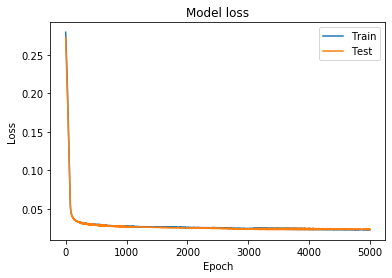

In [7]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right');
# plt.savefig("{}_learning_curve.png".format(model_name)

In [8]:
# K-Fold with the same hyperparameters
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
component_cvscores = []
split = 1

for train_index, test_index in kfold.split(X, Y):
    
    network = Sequential([
        Dense(25, activation=tf.nn.relu, input_shape=(5,)),
        Dense(20, activation=tf.nn.relu),
        Dense(15, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense( 4, activation=tf.nn.sigmoid)
    ])
        
    network.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    network.fit(X[train_index], Y[train_index], epochs=epochs,
              validation_split = 0.0, batch_size=X[train_index].shape[0], shuffle=False, verbose=0)
    scores = network.evaluate(X[test_index], Y[test_index], verbose=0)
    Y_pred = network.predict(X[test_index])
    component_cvscores.append(np.mean(np.absolute(Y_pred - Y[test_index]) / Y[test_index]*100, axis=0))
    print("Mean absolute percentage error (split{0}): {1}%".format(split, scores[1]))
    cvscores.append(scores[1])
    split += 1

print("\nAverage percentage error and std: {0}% (+/- {1}%)".format(np.mean(cvscores), np.std(cvscores))) 
print("\nMean absolute percentage error for every component:", np.mean(component_cvscores, axis = 0), sep="\n")

Mean absolute percentage error (split1): 13.162382125854492%
Mean absolute percentage error (split2): 15.52647590637207%
Mean absolute percentage error (split3): 19.15827751159668%
Mean absolute percentage error (split4): 13.835570335388184%
Mean absolute percentage error (split5): 14.449309349060059%

Average percentage error and std: 15.226404190063477% (+/- 2.114150047302246%)

Mean absolute percentage error for every component:
[15.85990109 10.91132473 12.4493181  21.68506758]


## Continuity check

In [19]:
def plot_continuity(df, constants, parameter, model, scaler):
    """Plot continuity with respect to choosen parameter."""
    
    colors = ["blue", "red", "green", "orange"]
    labels_exp = ["CH$_4$ (experiment)", "H$_2$ (experiment)", "CO$_2$ (experiment)", "CO (experiment)"]
    labels_model = ["CH$_4$ (network)", "H$_2$ (network)", "CO$_2$ (network)", "CO (network)"]
    
    if df.shape[0] == 1:
        t_min = df["t_center"].min() - 50
        t_max = t_min + 100
    else:
           t_min, t_max = df["t_center"].min(), df["t_center"].max()
            
    t_dense = np.linspace(t_min, t_max, 200)
    
    x = df.iloc[0, :5]
    X = pd.DataFrame(columns=x.index)
    X = X.append([x]*t_dense.size, ignore_index=True)
    X["t_center"] = t_dense
    X = scaler.transform(X)
    y = model.predict(X)
    
    fig = plt.figure(figsize=(14,10))
    ax = plt.axes()
    for n, component in enumerate(df.columns[5:]):
        ax.scatter(df[parameter], df[component], s=25, color=colors[n], label=labels_exp[n])
        ax.plot(t_dense, y[:, n], color=colors[n], label=labels_model[n])
    
    ax.set_xlabel(r'$T_{\rm center}$ [K]', fontsize=18)
    ax.set_ylabel('Zawartość składnika [-]', fontsize=18)
    fig.legend();
    plt.close(fig)
    
    return fig

In [17]:
# %%capture
constants = ["ch4_flow", "nc", "sc", "m_Ni"]
parameter = "t_center"
plots_path = "../figs/all_continuity_figs/trained_on_mean"

inputs4 = dataset.loc[:, :"m_Ni"].drop(parameter, axis=1).drop_duplicates()

n_fig = 1
for uq_input in inputs4.iterrows():
    fig_set = dataset.loc[(dataset.loc[:, :"m_Ni"].drop(parameter, axis=1) == uq_input[1]).all(axis=1), :]
    path = os.path.join(plots_path, "continuity_plot{}".format(n_fig))
    plot_continuity(fig_set, constants, parameter, network, scaler).savefig(path)
    
    n_fig += 1

# Training on median values

In [11]:
filepath_median = "../experimental_data/data_median.csv"
dataset = pd.read_csv(filepath_median, sep=",")
dataset.head()

,ch4_flow,t_center,nc,sc,m_Ni,ch4,h2,co2,co
0,50.0,600.0,3.0,3.0,0.174717,0.203193,0.624000,0.118755,0.055666
1,50.0,625.0,3.0,3.0,0.174717,0.173317,0.649135,0.114745,0.071690
2,35.0,625.0,4.0,5.0,0.174717,0.130320,0.680765,0.117609,0.070907
3,47.0,625.0,0.5,6.0,0.174717,0.137709,0.675302,0.132105,0.053022
4,50.0,625.0,2.0,4.0,0.174717,0.156592,0.659526,0.130412,0.057000


In [12]:
X = dataset.loc[:, :"m_Ni"].values
Y = dataset.loc[:, "ch4":].values

# Scale data 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0)


In [13]:
# Save scaler to file
scaler_filename = "median_scaler_temp.save"
# joblib.dump(scaler, scaler_filename)

In [14]:
model_name = "network_median"
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
# early_stopping_monitor = EarlyStopping(patience=10)
loss = "mae"
metrics = ["mape"]
epochs = 5000

network = Sequential([
    Dense(25, activation=tf.nn.relu, input_shape=(5,)),
    Dense(20, activation=tf.nn.relu),
    Dense(15, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.relu),
    Dense( 4, activation=tf.nn.sigmoid)
])

network.compile(loss=loss, optimizer=optimizer, metrics=metrics)
hist = network.fit(X_train, Y_train, batch_size=X_train.shape[0], epochs=epochs, verbose=0,
                 validation_data=(X_test, Y_test), shuffle=False)

In [15]:
# Save network model to file
# network.save("{}_model.h5".format(model_name))

# Save train history to file
# with open("{}_trainHistoryDict.pickle".format(model_name), "wb") as file_obj:
#     pickle.dump(hist.history, file_obj)

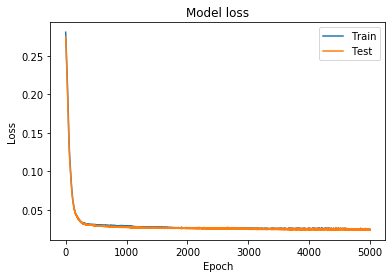

In [16]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right');
# plt.savefig("{}_learning_curve.png".format(model_name)

In [17]:
# K-Fold with the same hyperparameters
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
component_cvscores = []
split = 1

for train_index, test_index in kfold.split(X, Y):
    
    network = Sequential([
        Dense(25, activation=tf.nn.relu, input_shape=(5,)),
        Dense(20, activation=tf.nn.relu),
        Dense(15, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense( 4, activation=tf.nn.sigmoid)
    ])
        
    network.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    network.fit(X[train_index], Y[train_index], epochs=epochs,
              validation_split = 0.0, batch_size=X[train_index].shape[0], shuffle=False, verbose=0)
    scores = network.evaluate(X[test_index], Y[test_index], verbose=0)
    Y_pred = network.predict(X[test_index])
    component_cvscores.append(np.mean(np.absolute(Y_pred - Y[test_index]) / Y[test_index]*100, axis=0))
    print("Mean absolute percentage error (split{0}): {1}%".format(split, scores[1]))
    cvscores.append(scores[1])
    split += 1

print("\nAverage percentage error and std: {0}% (+/- {1}%)".format(np.mean(cvscores), np.std(cvscores))) 
print("\nMean absolute percentage error for every component:", np.mean(component_cvscores, axis = 0), sep="\n")

Mean absolute percentage error (split1): 13.58431339263916%
Mean absolute percentage error (split2): 14.404219627380371%
Mean absolute percentage error (split3): 20.077415466308594%
Mean absolute percentage error (split4): 14.327850341796875%
Mean absolute percentage error (split5): 15.544496536254883%

Average percentage error and std: 15.587658882141113% (+/- 2.330700159072876%)

Mean absolute percentage error for every component:
[16.61306915 11.15898115 12.55840097 22.0201849 ]
